In [5]:
import os
import scipy.io as sio
import sys 
import h5py as hp
import argparse
import random
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift
from scipy.signal import convolve2d, correlate2d
from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))

def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)
#load exp data

filename = [#one interval
            "expdata/153S_0-106_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153L_106-180_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153A_180_250_1000frame_100us_50ms_180GAIN_1_MMStack_Default.ome.tif",
            "expdata/153B_250_300_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153c_300_355_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153D_355_425_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153E_425_500_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153I_500-1000_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            #two interval
            "expdata/153P_250-106_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153K_180-300_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153F_250_355_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153G_300_425_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153M_355-500_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            #three interval
            "expdata/153N_180-355_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153T_250-425_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153J_300-500_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153R_355-1000_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            #four interval
            "expdata/153Q_425-180_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            "expdata/153O_500-250_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            #five interval
            "../expdata/153H_180_500_1000frame_100us_50ms_180GAIN_slow_1_MMStack_Default.ome.tif",
            ]
name = [#one interval
        '0-106 μm',
        '106-180 μm',
        '180-250 μm',
        '250-300 μm',
        '300-355 μm',
        '355-425 μm',
        '425-500 μm',
        '500-1000 μm',
        #two interval
        '106-250 μm',
        '180-300 μm',
        '250-355 μm',
        '300-425 μm',
        '355-500 μm',
        #three interval
        '180-355 μm',
        '250-425 μm',
        '300-500 μm',
        '355-1000 μm',
        #four interval
        '180-425 μm',
        '250-500 μm',
        #five interval
        '180-500 μm']



In [6]:
idx = -1 #choose a file to load 

#Raw speckle intensity datatest
datatest = imread(filename[idx])[:,:,:]/2**16  #16-bit pixel type. Normalize its maximum to 1
print(np.amax(datatest))

#calculate the autocorrelation for each frame
autotest= np.zeros((1000,1224,1832))  # frames x height x weidth
for i in tqdm(range(1000)):
    datatest[i] = (datatest[i]-np.amin(datatest[i]))/(np.amax(datatest[i])-np.amin(datatest[i]))
    at = np.abs(autocor2d(datatest[i]))
    at = (at-np.mean(datatest[i])**2)/(np.mean(datatest[i]**2)-(np.mean(datatest[i]))**2)
    autotest[i] = at



#Crop the autocorrelation into 128 x 128 to reduce the volume.
autotest_ = autotest - np.amin(np.mean(autotest,axis=0))
autotest_ = autotest_[:,
                      (-128+1224)//2 : (128+1224)//2,
                     (-128+1832)//2 : (128+1832)//2]

#save it as npz file
# np.savez(filename[-1]+"_auto",auto=autotest_)


0.99951171875


<ipython-input-22-98283024377d>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')
<ipython-input-22-98283024377d>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Text(0.5, 1.0, 'Raw image (zoom in) @ frame 900')

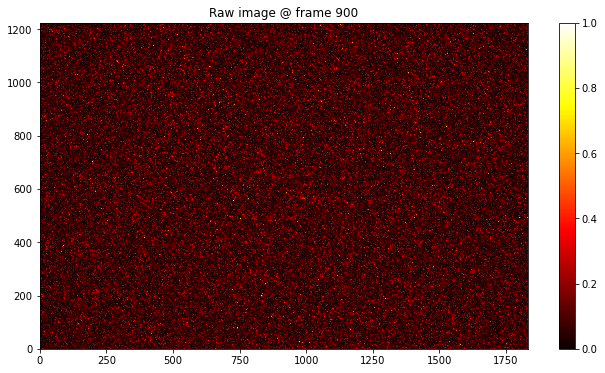

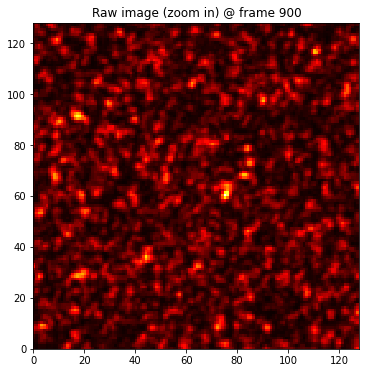

In [22]:
#plot the raw image at certain frame
frame_idx = 900
plt.figure(figsize=(11,6))
plt.pcolormesh(datatest[frame_idx,:,:],cmap=plt.cm.hot)
plt.colorbar()
plt.axes().set_aspect('equal')
plt.title("Raw image @ frame " + str(frame_idx))

plt.figure(figsize=(6,6))
plt.pcolormesh(datatest[frame_idx,500:628,500:628],cmap=plt.cm.hot)
plt.axes().set_aspect('equal')
plt.title("Raw image (zoom in) @ frame " + str(frame_idx))

<ipython-input-23-a86f65d6cef0>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')
<ipython-input-23-a86f65d6cef0>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Text(0.5, 1.0, '200 frame averaged autocorrelations for 180-500 μm')

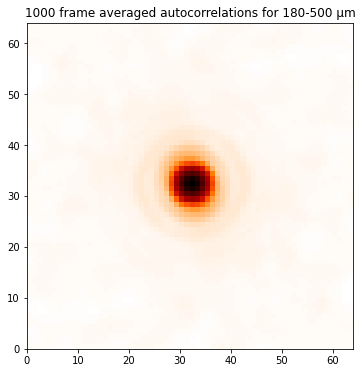

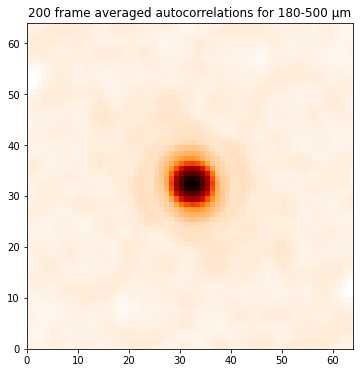

In [23]:
#1000 avraged autocorrelation
autotest_mean = np.mean(autotest, axis=0)

#200 avraged autocorrelation
autotest_mean_2 = np.mean(autotest[0:200],axis=0)

#plot the 1000 avraged autocorrelation
plt.figure(figsize=(6,6))
plt.pcolormesh(np.abs(centralpadding((autotest_mean-np.amin(autotest_mean))**0.125,(64,64))),cmap=plt.cm.gist_heat_r,
                label = name[1])
# plt.colorbar()
plt.axes().set_aspect('equal')
plt.title("1000 frame averaged autocorrelations for " + name[idx])


#plot the 200 avraged autocorrelation
plt.figure(figsize=(6,6))
plt.pcolormesh(np.abs(centralpadding((autotest_mean_2-np.amin(autotest_mean_2))**0.125,(64,64))),cmap=plt.cm.gist_heat_r,
              label = name[1])
# plt.colorbar()
plt.axes().set_aspect('equal')
plt.title("200 frame averaged autocorrelations for " + name[idx])